# Xinyue Lu final project - online shopping success classification

## 1. Topic discussion

Online shopping is one of the most important aspects of revenue generation of a e-commerce company, like Amazon/Ebay. Company typically has lots of data of user footprint, including user personal information and user behavior pattern, and they want to use those info to predict if a user can eventually make a shopping event, which brings cash income to company.

The goal is to utilize features available to e-commerce, to predict if a shopping can happen or not. This question is essential since it will help online shopping companies to know which factors are most important to lead potential customers to spend money, and thus shopping companies can tune their marketing strategy. They can even use the prediction to allocate their merchantise/inventory before the shopping events happen, in order to optimize the delivery time and reduce transportation cost.

This question is by nature a `classification` problem, because the target variable we are interested in, is a binary (whether or not a user ends up with a shopping).

The data source comes from UC Irvine ML repository.
https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

Sakar,C. and Kastro,Yomi. (2018). Online Shoppers Purchasing Intention Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5F88Q.

In this project, I would use **logistic regression** to predict the classification, while also explore hyper-parameter tuning and skewed dataset analysis.

## 2. EDA

In [177]:
# importing all the required libraries

# common util lib
from math import exp
import copy
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

# ML model lib
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

# plot lib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set color map to have light blue background
sns.set()

In [6]:
raw_df = pd.read_csv('online_shoppers_intention.csv')

### 2.1 First, let's take a brief look at the data, like the data format/data type.

In [10]:
raw_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [11]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

#### The data has 12330 data entries, with 18 variables: 17 features and 1 target (Revenue).


### 2.2 Variables meaning analysis
**target (dependent variable):**

Revenue: bool
- if an open session ends up with shopping event. That's what we want to predict.


**features (independent variable):**

Administrative: numeric
- a type of webpage. The value means how many this type of pages are visited in this session (count).

Informational: numeric
- a type of webpage. The value means how many this type of pages are visited in this session (count).

ProductRelated: numeric
- a type of webpage. The value means how many this type of pages are visited in this session (count).

Administrative_Duration: numeric
- a type of webpage. The value means how long this type of pages are visited in this session (duration).

Informational_Duration: numeric
- a type of webpage. The value means how long this type of pages are visited in this session (duration).

ProductRelated_Duration: numeric
- a type of webpage. The value means how long this type of pages are visited in this session (duration).
    
BounceRates: numeric
- the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.
  
ExitRates: numeric
- for all pageviews to the page, the percentage that were the last in the session.
    
PageValues: numeric
- the average value for a web page that a user visited before completing an e-commerce transaction.
    
SpecialDay: numeric
- closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. 
    
Month: categorical
- which month of the year did the user session happen.

OperatingSystems: categorical
- which OS the user is using. In data set, it is represented by integer.

Browser: categorical
- which Browser the user is using. In data set, it is represented by integer.

Region: categorical
- which Region the user is located. In data set, it is represented by integer.

TrafficType: categorical
- which TrafficType the user belongs to. In data set, it is represented by integer.

VisitorType: categorical
- which VisitorType the user belongs to. In data set, it is represented by String.

Weekend: bool
- Whether this session happens during weekend or not.


In [13]:

raw_df.groupby('Revenue')['Month'].count()

Revenue
False    10422
True      1908
Name: Month, dtype: int64

we can see we have 10422 false samples (no shopping) and 1908 true samples (with shopping)

In [22]:
total_cols = list(raw_df.columns)
numeric_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


18, 10, 8
Administrative
Administrative_Duration
Informational
Informational_Duration
ProductRelated
ProductRelated_Duration
BounceRates
ExitRates
PageValues
SpecialDay
Month
OperatingSystems
Browser
Region
TrafficType
VisitorType
Weekend
Revenue



### 2.3 Variable statistics analysis

In [29]:
# numeric variables, min/max/medium/mean
for col in numeric_cols:
    print(raw_df[col].describe())
    print("----")
    print("")

count    12330.000000
mean         2.315166
std          3.321784
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         27.000000
Name: Administrative, dtype: float64
----

count    12330.000000
mean        80.818611
std        176.779107
min          0.000000
25%          0.000000
50%          7.500000
75%         93.256250
max       3398.750000
Name: Administrative_Duration, dtype: float64
----

count    12330.000000
mean         0.503569
std          1.270156
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.000000
Name: Informational, dtype: float64
----

count    12330.000000
mean        34.472398
std        140.749294
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2549.375000
Name: Informational_Duration, dtype: float64
----

count    12330.000000
mean        31.731468
std         44.475503
min          0.000000
25%          7.00000

In [32]:
# categorical, unique value
for col in categorical_cols:
    print(f"column: {col}, unique values: {raw_df[col].unique()}")


column: Month, unique values: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
column: OperatingSystems, unique values: [1 2 4 3 7 6 8 5]
column: Browser, unique values: [ 1  2  3  4  5  6  7 10  8  9 12 13 11]
column: Region, unique values: [1 9 2 3 4 5 6 7 8]
column: TrafficType, unique values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]
column: VisitorType, unique values: ['Returning_Visitor' 'New_Visitor' 'Other']
column: Weekend, unique values: [False  True]
column: Revenue, unique values: [False  True]


### 2.4 Variable type/format analysis

For all numeric variables, as mentioned above in raw_df.info(), their data type are either integer or float, and they are well formatted.

For categorical variables, they might be integer/bool/string object. `We need to clean them up later`, for example, we want to unify the format of binary variables, converting them to 0 and 1. 

## 3. Data clean up
This step is needed no matter what ML algo we want to choose.

### 3.1 null value evaluation
we have in total 12330 entries, and all of the features have 12330 non-null count as shown above.
so we don't need null value clean up, but other clean up is needed, as discussed below.

### 3.2 dirty data clean up
I notice we have a small amount of data (<1%) whose **visitor type** is `other` (meaning, unknown).
Those data may not provide any explanation power to our model, since anything can happen under this category.
Therefore, they will bring noise to our model.

I propose to remove them.

In [59]:
raw_df.groupby('VisitorType')['Month'].count()

VisitorType
New_Visitor           1694
Other                   85
Returning_Visitor    10551
Name: Month, dtype: int64

In [96]:
formatted_df = raw_df[raw_df['VisitorType']!="Other"]
formatted_df.shape

(12245, 18)

Then we treat VisitorType as `binary`: new customer as baseline (0), and returning customer as 1.
Later the model coefficient will mean, compared to new customer, 
if this is a returing customer, how much difference it will make?

In [97]:

visitor_type_mapping = {'New_Visitor': 0, 'Returning_Visitor': 1}
formatted_df["VisitorType"] = formatted_df["VisitorType"].apply(lambda vtype: visitor_type_mapping[vtype])
formatted_df['VisitorType'].unique()

array([1, 0])

In [98]:
# comparing with the same groupby count command above, to make sure our mapping is correct.
formatted_df.groupby('VisitorType')['Month'].count()

VisitorType
0     1694
1    10551
Name: Month, dtype: int64

Now we can confirm the mapping is correct.

### 3.3 Format clean up
We want to make sure columns are well formatted. For example, we want to unify the format of binary variables, converting them to 0 and 1. 

In [99]:
# convert all binary types to 0 and 1
binary_cols = ['Weekend', 'Revenue']

for col in binary_cols:
    print(f"Before conversion, the column {col} count looks like: {formatted_df.groupby(col)['Month'].count()}")
    formatted_df[col] = formatted_df[col].apply(lambda bool_val: 1 if bool_val else 0)
    print(f"column: {col}, unique values: {formatted_df[col].unique()}")
    print(f"After conversion, the column {col} count looks like: {formatted_df.groupby(col)['Month'].count()}")
    print("----")


Before conversion, the column Weekend count looks like: Weekend
False    9384
True     2861
Name: Month, dtype: int64
column: Weekend, unique values: [0 1]
After conversion, the column Weekend count looks like: Weekend
0    9384
1    2861
Name: Month, dtype: int64
----
Before conversion, the column Revenue count looks like: Revenue
False    10353
True      1892
Name: Month, dtype: int64
column: Revenue, unique values: [0 1]
After conversion, the column Revenue count looks like: Revenue
0    10353
1     1892
Name: Month, dtype: int64
----


At the end of `step 3. Data clean up`, we removed some dirty data, and convert all binary fields to the format of 0 and 1.

## 4. Feature cleanup


### 4.1 Feature relationship

Let's first investigate what is needed for `logistic regression`.
I want to remove these following features:
- Month: we want to find out the prediction relationship on an overall basis. Seasonality adjustment is out of scope.
- 'OperatingSystems', 'Browser', 'Region', 'TrafficType': Those categorical features are hard to interpret. The data provider doesn't give meaning of what each of the integers stands for, so I cannot find a proper meaningful baseline. Also all of those features have too many (at least 8) unique values, so in each category there might not be enough data points, making the coefficient meaningless.


In [101]:
logistic_df = formatted_df.drop(columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType'], inplace=False)
logistic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12245 entries, 0 to 12329
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12245 non-null  int64  
 1   Administrative_Duration  12245 non-null  float64
 2   Informational            12245 non-null  int64  
 3   Informational_Duration   12245 non-null  float64
 4   ProductRelated           12245 non-null  int64  
 5   ProductRelated_Duration  12245 non-null  float64
 6   BounceRates              12245 non-null  float64
 7   ExitRates                12245 non-null  float64
 8   PageValues               12245 non-null  float64
 9   SpecialDay               12245 non-null  float64
 10  VisitorType              12245 non-null  int64  
 11  Weekend                  12245 non-null  int64  
 12  Revenue                  12245 non-null  int64  
dtypes: float64(7), int64(6)
memory usage: 1.3 MB


Now we can see all data types are either int or float. No string object exists any more

/Users/xinyuelu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


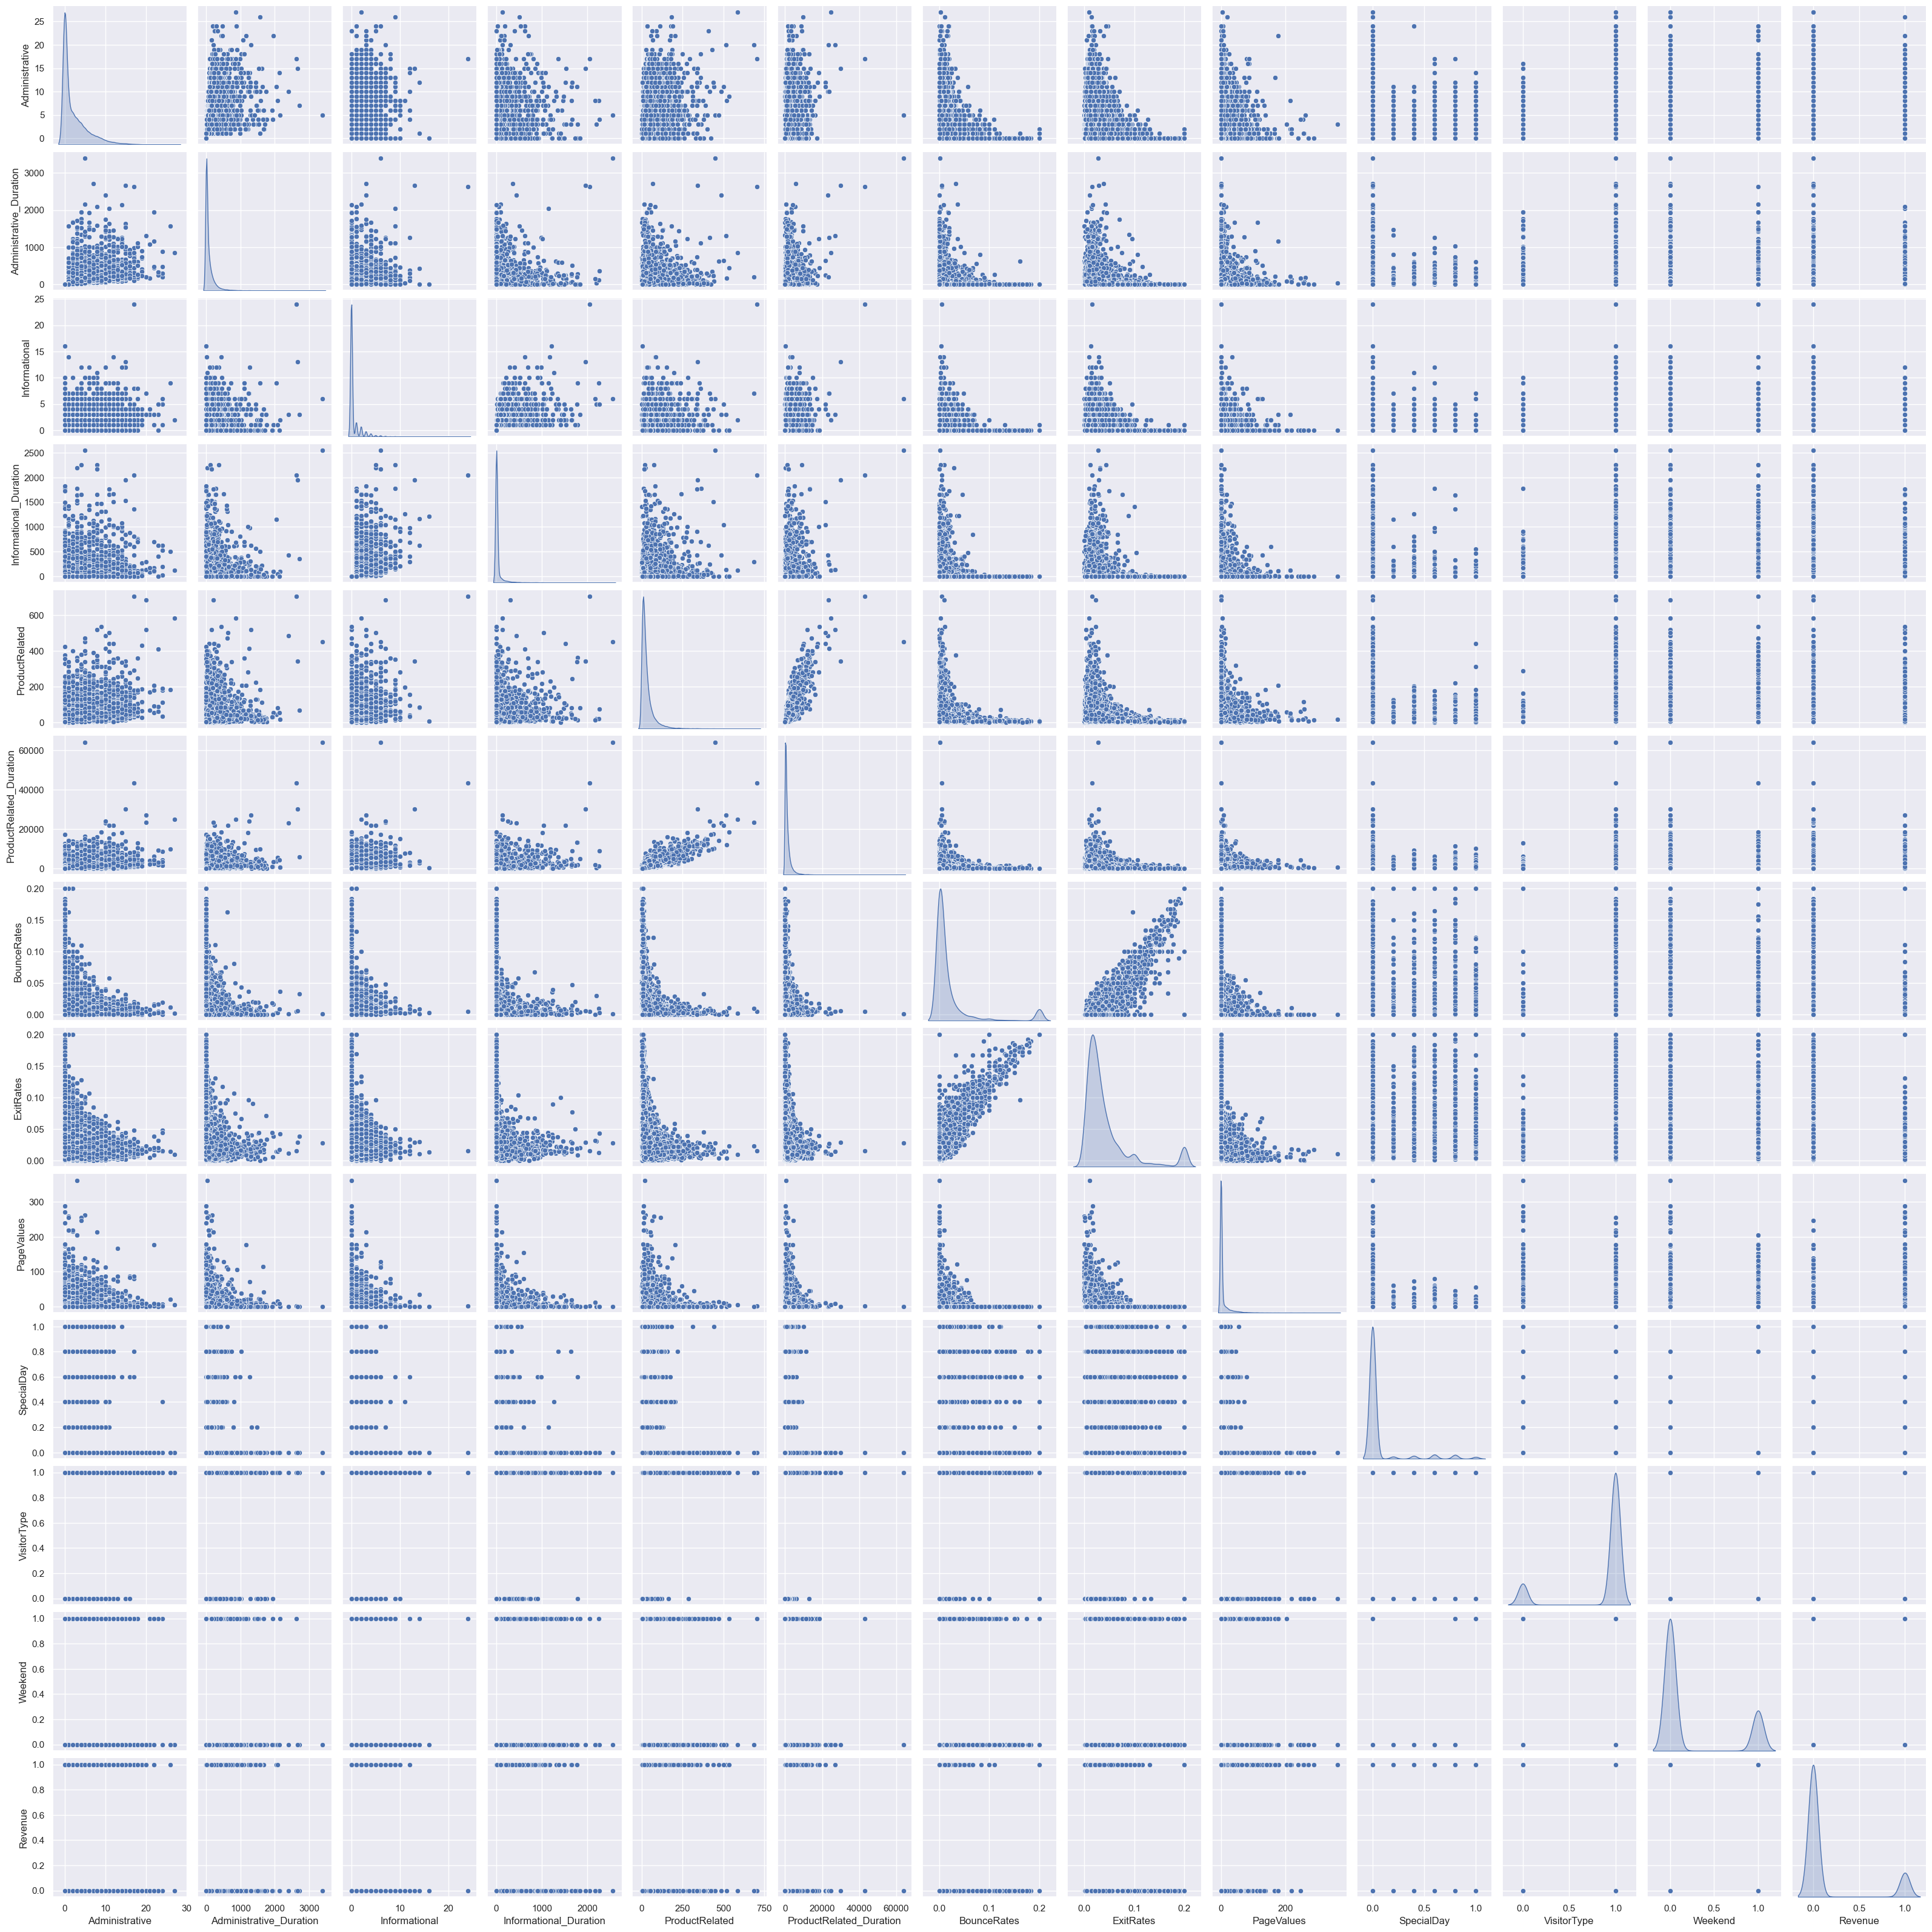

In [108]:
pairplot = sns.pairplot(logistic_df, diag_kind='kde')

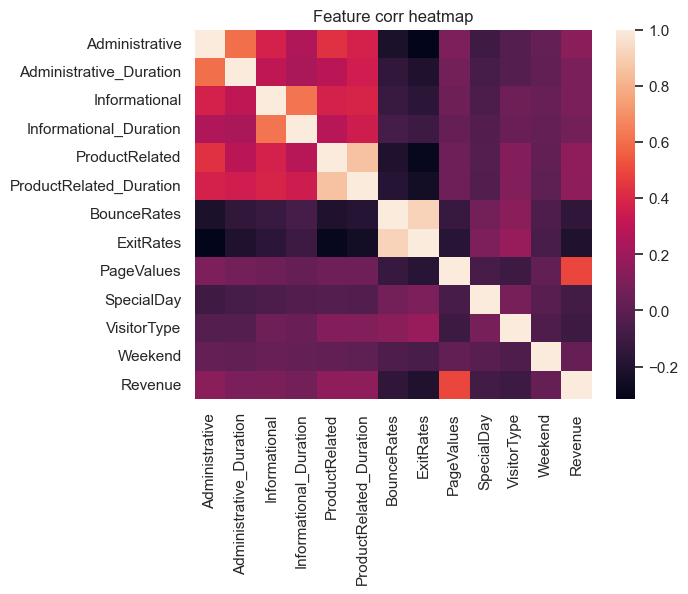

correlation matrix values:


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,VisitorType,Weekend,Revenue
Administrative,1.000000,0.602760,0.377532,0.256053,0.431881,0.374776,-0.223112,-0.315791,0.103448,-0.095562,-0.027820,0.026028,0.138901
Administrative_Duration,0.602760,1.000000,0.303982,0.238399,0.290465,0.357260,-0.143989,-0.205379,0.071303,-0.073886,-0.024887,0.015182,0.093537
Informational,0.377532,0.303982,1.000000,0.618961,0.373345,0.386930,-0.116261,-0.163801,0.052323,-0.048848,0.054240,0.035295,0.095666
Informational_Duration,0.256053,0.238399,0.618961,1.000000,0.279715,0.347328,-0.074121,-0.105279,0.033179,-0.030956,0.043703,0.023440,0.070412
ProductRelated,0.431881,0.290465,0.373345,0.279715,1.000000,0.860697,-0.204902,-0.292671,0.057855,-0.024940,0.124223,0.015232,0.158780
ProductRelated_Duration,0.374776,0.357260,0.386930,0.347328,0.860697,1.000000,-0.184676,-0.251832,0.054523,-0.037161,0.117634,0.006684,0.152193
BounceRates,-0.223112,-0.143989,-0.116261,-0.074121,-0.204902,-0.184676,1.000000,0.912720,-0.120570,0.074143,0.139801,-0.046721,-0.150114
ExitRates,-0.315791,-0.205379,-0.163801,-0.105279,-0.292671,-0.251832,0.912720,1.000000,-0.175643,0.103995,0.184305,-0.062456,-0.206090
PageValues,0.103448,0.071303,0.052323,0.033179,0.057855,0.054523,-0.120570,-0.175643,1.000000,-0.064057,-0.110141,0.015109,0.494959
SpecialDay,-0.095562,-0.073886,-0.048848,-0.030956,-0.024940,-0.037161,0.074143,0.103995,-0.064057,1.000000,0.083670,-0.017569,-0.082468


In [107]:
# investigate feature relationship
corr_matrix = logistic_df.corr()
ax = plt.axes()

g_heatmap = sns.heatmap(corr_matrix, ax = ax)
ax.set_title('Feature corr heatmap')
plt.show()
print("correlation matrix values:")
corr_matrix

For preliminary investigation, I have a few findings:
- `PageValues` seems to be the feature with highest positive correlation with our target `Revenue`. It might be the best predicator. Need investigate further.
- Not surprisingly, Administrative/Informational/ProductRelated page types and their corresponding durations have high positive correlation (>0.6), so we might try to remove some later.
- `BounceRates` and `ExitRates` has very strong positive correlation of 0.912720, which indicator strong `collinearity`. We might need to remove one of them.

### 4.2 Feature selection.

There are a few considerations when i do feature selection:
#### 4.2.1. Collinearity 
Collinearity might do harm to the feature stabilization, causing significant features no longer significant.
To further investigate collinearity, I use Variance Inflation Factor (VIF) for each variable.
- To calculate VIF, I need to do `linear regression` of each feature against all other features, and use the generated `R_squrared` value to evaluate.


#### 4.2.2. p value
This is the standard way to investigate feature significance.

In [123]:
# VIF investigation

all_variables = set(logistic_df.columns)
all_features = all_variables.copy()
all_features.remove('Revenue')

def get_feature_vif(df, all_features):
    vif = dict()
    for feature in all_features:
        other_features = all_features.copy()
        other_features.remove(feature)
        formula = "+".join(list(other_features))

        handler = smf.ols(
            formula=f"{feature} ~ {formula}", 
            data=df)
        vif_model = handler.fit()
        r2 = vif_model.rsquared
        vif[feature] = 1/(1-r2)
        print(f"for feature {feature}, the R2 from other features is {r2}. VFI={vif[feature]}")
    return vif
    
get_feature_vif(logistic_df, all_features)

for feature Informational_Duration, the R2 from other features is 0.4041678953186094. VFI=1.6783251391509528
for feature Informational, the R2 from other features is 0.4537995362049111. VFI=1.8308296427502802
for feature BounceRates, the R2 from other features is 0.8429609091363608. VFI=6.367841245771881
for feature ExitRates, the R2 from other features is 0.8592309907024698. VFI=7.103836313050936
for feature PageValues, the R2 from other features is 0.04852080246021662. VFI=1.0509951269409523
for feature Administrative, the R2 from other features is 0.4866589633555626. VFI=1.9480227151460794
for feature VisitorType, the R2 from other features is 0.09026171321952303. VFI=1.0992172304179426
for feature Weekend, the R2 from other features is 0.006816564605967912. VFI=1.0068633490683054
for feature ProductRelated, the R2 from other features is 0.773813660492606. VFI=4.421133487450555
for feature SpecialDay, the R2 from other features is 0.02431774522791319. VFI=1.024923836739855
for featu

{'Informational_Duration': 1.6783251391509528,
 'Informational': 1.8308296427502802,
 'BounceRates': 6.367841245771881,
 'ExitRates': 7.103836313050936,
 'PageValues': 1.0509951269409523,
 'Administrative': 1.9480227151460794,
 'VisitorType': 1.0992172304179426,
 'Weekend': 1.0068633490683054,
 'ProductRelated': 4.421133487450555,
 'SpecialDay': 1.024923836739855,
 'Administrative_Duration': 1.6963349783977584,
 'ProductRelated_Duration': 4.327479720909333}

**From VIF approach, those following features are subject to multi-collinearity:
`BounceRates`, `ExitRates`, `ProductRelated`, `ProductRelated_Duration`**

In [130]:
# p-value investigation

logistic_X = logistic_df.drop(columns=["Revenue"])
logistic_Y = logistic_df["Revenue"]
# Add constant term to predictor variables
logistic_X = sm.add_constant(logistic_X)

def get_significant_features(X, Y):
    model = sm.Logit(Y, X)
    result = model.fit()

    print(result.summary())

    p_values = result.pvalues.drop('const')  # Drop constant term from p-values
    significance_threshold = 0.05
    significant_features = p_values[p_values < significance_threshold].index
    print("Significant features:", significant_features)
    
get_significant_features(logistic_X, logistic_Y)

Optimization terminated successfully.
         Current function value: 0.300759
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                Revenue   No. Observations:                12245
Model:                          Logit   Df Residuals:                    12232
Method:                           MLE   Df Model:                           12
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.3013
Time:                        22:22:47   Log-Likelihood:                -3682.8
converged:                       True   LL-Null:                       -5270.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.8375      0.091    -20.213      0.000      -2.016   

**From p_value approach, those following features are NOT significant:
`Administrative`, `Administrative_Duration`, `Informational`, `Informational_Duration`, `BounceRates`, `Weekend`**

Combining the info from VIF and p-value, I decide to remove the following features. 
- all durations-features: Administrative_Duration, Informational_Duration, ProductRelated_Duration
  - reason: compared to the corresponding number of pages feature (like ProductRelated), the duration-features typically have higher p-value. Also, from the statistic above, the mean/std is lower for duration-features, meaning duration-features have higher variation and thus might have more outliers/high leverage data points.
- BounceRates
  - reason: As mentioned above in corr analysis, bounceRate and ExitRates have high correlation. BounceRates p-value=0.318 while ExitRates p-value=0.000, so keep ExitRates and remove bounceRate.

In [124]:
features_to_be_removed = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", "BounceRates"]

In [131]:
# 1st round feature cleanup

cleaned_features = all_features.copy()
for f_removal in features_to_be_removed:
    cleaned_features.remove(f_removal)
    
get_feature_vif(logistic_df, cleaned_features)

logistic_X_cleaned = logistic_X.drop(columns=features_to_be_removed)
get_significant_features(logistic_X_cleaned, logistic_Y)

for feature SpecialDay, the R2 from other features is 0.022090808648272953. VFI=1.0225898364016168
for feature Informational, the R2 from other features is 0.19902989257500003. VFI=1.2484860430245663
for feature ExitRates, the R2 from other features is 0.1905938807638895. VFI=1.2354737334377524
for feature PageValues, the R2 from other features is 0.041493987331302606. VFI=1.0432902733867824
for feature Administrative, the R2 from other features is 0.2807698571357846. VFI=1.3903755424065862
for feature Weekend, the R2 from other features is 0.006087720949743525. VFI=1.0061250082910342
for feature ProductRelated, the R2 from other features is 0.28534596082740893. VFI=1.3992784552897448
for feature VisitorType, the R2 from other features is 0.08223768739169657. VFI=1.0896067383263701
Optimization terminated successfully.
         Current function value: 0.301025
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            

We can see, all features VIF is now under 2, which means the multicollinearity issue is mitigated.
However, there are 3 features still having high p value: `Administrative`, `Informational`, `Weekend`.
- I propose to do a 2nd round feature cleanup, to remove them.

In [132]:
# 2nd round clean up
features_to_be_removed_v2 = ["Administrative", "Informational", "Weekend"]

cleaned_features_v2 = cleaned_features.copy()
for f_removal in features_to_be_removed_v2:
    cleaned_features_v2.remove(f_removal)
    
get_feature_vif(logistic_df, cleaned_features_v2)

logistic_X_cleaned_v2 = logistic_X_cleaned.drop(columns=features_to_be_removed_v2)
get_significant_features(logistic_X_cleaned_v2, logistic_Y)

for feature ExitRates, the R2 from other features is 0.1579374933849651. VFI=1.1875602964675986
for feature PageValues, the R2 from other features is 0.0392627880875106. VFI=1.0408673543615035
for feature VisitorType, the R2 from other features is 0.078738752995962. VFI=1.0854684306455114
for feature ProductRelated, the R2 from other features is 0.11899437257342693. VFI=1.1350665295078883
for feature SpecialDay, the R2 from other features is 0.016868274147374573. VFI=1.0171576948478043
Optimization terminated successfully.
         Current function value: 0.301276
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                Revenue   No. Observations:                12245
Model:                          Logit   Df Residuals:                    12239
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.3001
Time:       

**Here, I get the final feature list: `'ProductRelated', 'ExitRates', 'PageValues', 'SpecialDay', 'VisitorType'`**

## 5. Model evaluation and result analysis

A few performance metrics are worth noticing:
- Precision
- Recall
- Accuracy
- Area under ROC curve (AUC)

In [150]:
# let's do a 3-1 split for training and testing dataset.
# this is the REAL feature sets after feature selection above.
x_train, x_test, y_train, y_test = train_test_split(logistic_X_cleaned_v2, logistic_Y, test_size=0.25, random_state=5)

# the following are NOT the proposed-to-use features, but just for some playing/comparison purpose
# keep the random state the same
x_train_uncleaned, x_test_uncleaned, y_train_uncleaned, y_test_uncleaned = train_test_split(logistic_X, logistic_Y, test_size=0.25, random_state=5)
x_train_cleanV1, x_test_cleanV1, y_train_cleanV1, y_test_cleanV1 = train_test_split(logistic_X_cleaned, logistic_Y, test_size=0.25, random_state=5)

In [151]:
LogReg = LogisticRegression(solver='liblinear').fit(x_train, y_train)
LogReg_uncleaned = LogisticRegression(solver='liblinear').fit(x_train_uncleaned, y_train_uncleaned)
LogReg_cleanV1 = LogisticRegression(solver='liblinear').fit(x_train_cleanV1, y_train_cleanV1)

### 5.1 evaluation part 1: AUC and ROC measure

auc for test case Final selected feature model (5 features) : 0.8974950568254342


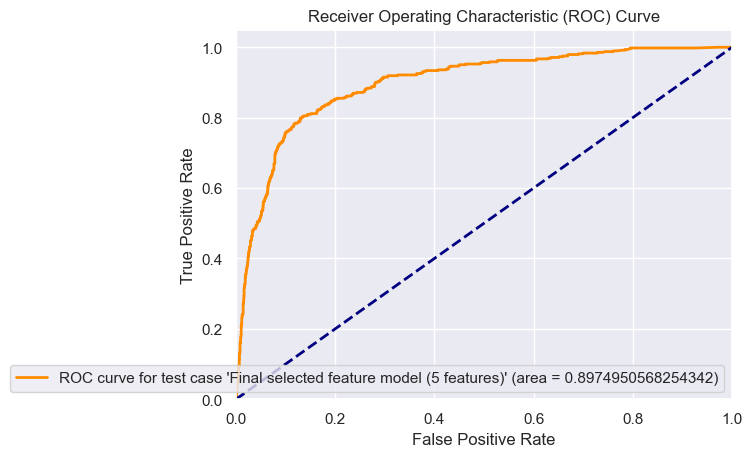

auc for test case Not-yet cleaned model (12 features) : 0.9000258498125889


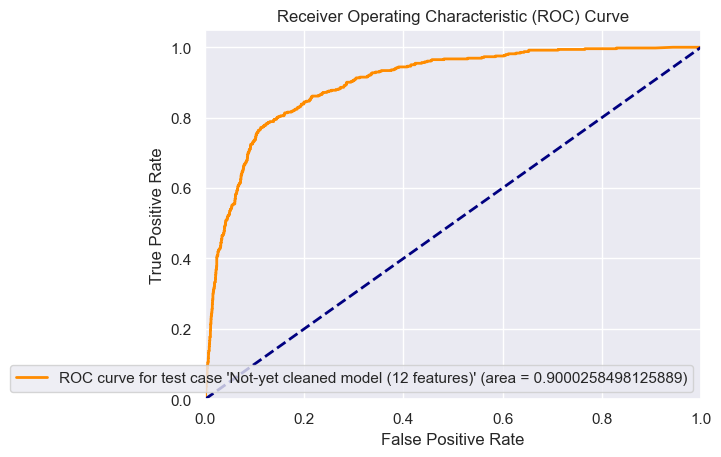

auc for test case 1st round cleaned model (8 features) : 0.8995088535608118


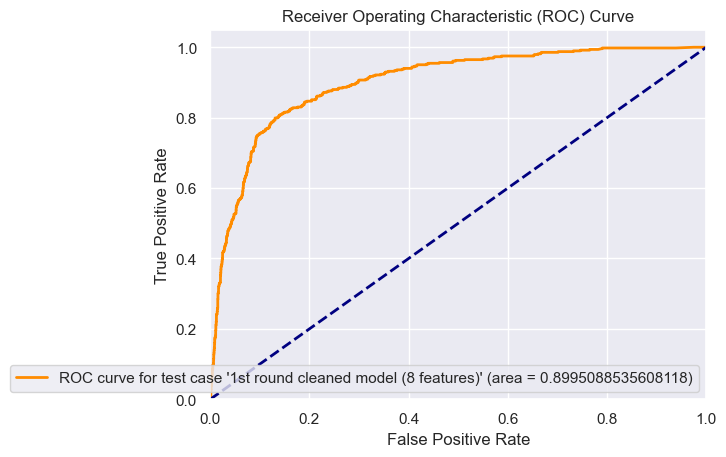

In [164]:
from sklearn.metrics import auc

y_pred_proba = LogReg.predict_proba(x_test)[:, 1]  # Probability of the positive class (class 1)
y_pred_proba_uncleaned = LogReg_uncleaned.predict_proba(x_test_uncleaned)[:, 1]  # Probability of the positive class (class 1)
y_pred_proba_cleanV1 = LogReg_cleanV1.predict_proba(x_test_cleanV1)[:, 1]  # Probability of the positive class (class 1)

def get_auc_and_plot_roc(y_test, y_pred_proba, test_case_name):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Calculate the AUC (Area Under the Curve)
    auc_val = auc(fpr, tpr)
    print(f"auc for test case {test_case_name} : {auc_val}")

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve for test case '{test_case_name}' (area = {auc_val})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
get_auc_and_plot_roc(y_test, y_pred_proba, "Final selected feature model (5 features)")
get_auc_and_plot_roc(y_test_uncleaned, y_pred_proba_uncleaned, "Not-yet cleaned model (12 features)")
get_auc_and_plot_roc(y_test_cleanV1, y_pred_proba_cleanV1, "1st round cleaned model (8 features)")

### 5.2 evaluation part 2: accuracy, precision, recall, F1 score

In [163]:
y_pred = LogReg.predict(x_test)
y_pred_uncleaned = LogReg_uncleaned.predict(x_test_uncleaned)
y_pred_cleanV1 = LogReg_cleanV1.predict(x_test_cleanV1)


def get_eval_metrics(y_test, y_pred, test_case_name):
    print(f"for '{test_case_name}', evaluation metrics: ")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, "
          f"F1 score: {(2*precision*recall/(precision+recall))}")

get_eval_metrics(y_test, y_pred, "Final selected feature model (5 features)")
get_eval_metrics(y_test_uncleaned, y_pred_uncleaned, "Not-yet cleaned model (12 features)")
get_eval_metrics(y_test_cleanV1, y_pred_cleanV1, "1st round cleaned model (8 features)")

for 'Final selected feature model (5 features)', evaluation metrics: 
Accuracy: 0.8827563683866754, Precision: 0.7627118644067796, Recall: 0.37267080745341613, F1 score: 0.5006954102920723
for 'Not-yet cleaned model (12 features)', evaluation metrics: 
Accuracy: 0.8814500326583932, Precision: 0.7542372881355932, Recall: 0.36853002070393376, F1 score: 0.4951321279554938
for '1st round cleaned model (8 features)', evaluation metrics: 
Accuracy: 0.8827563683866754, Precision: 0.7627118644067796, Recall: 0.37267080745341613, F1 score: 0.5006954102920723


### 5.3 Result and Performance Analysis
As we can see, at the very beginning we have 17 features (independent variables). I firstly removed a few categorical features which is hard to interpret. Then my logistic regression starts from 12 features (independent variables).

Then, after 2 rounds of clean up, the final selected feature model only has 5 features, but it can reach performance parity (accuracy/precision/recall) with models with much more features (12-feature model and 8-feature model, as shown above), from all aspects of performance evaluation.

For all of the models, the accuracy is ok (around 88%), but precision (76%) and recall (37%) are quite low. I will have further discussion later (in skewed dataset section).

Also, from the feature coefficients from logistic regression above (also copied below), we can see the direction of feature impact:

ProductRelated     0.0060      
ExitRates        -16.5807     
PageValues         0.0802      
SpecialDay        -0.9246      
VisitorType       -0.3498      

ProductRelated: positive impact. 
- Idea: e-commerce should try to increase ProductRelated webpages visit to boost sales.

ExitRates: negative impact.
- Idea: e-commerce should try to reduce ExitRates to boost sales.

PageValues: positive impact.
- Idea: e-commerce should try to increase PageValues to boost sales.

SpecialDay: negative impact.
- Idea: the closer to special day, the lower likelihood the potential customer will make a shopping.
  - It is somehow counter-intuitive to me, since holiday should by nature boost the sales. However I think there might be a few reasons to justify the negative correlation above.
    - The data was introduced in a paper published in May 2018, which means the data can be even older than that. By that time, before COVID, e-commerce is not as developed as now, so the data might be outdated.
    - There are multiple special days throughout the year, and only a few of them might boost shopping (like Black Friday). For other holidays, people might go out for travel and then don't make much online shopping.

VisitorType: negative impact.
- Idea: the negative impact of this boolean feature means, compared to new visitor (0), returning visitor (1) are less likely to make a purchase.
  - This pattern actually makes sense, and that might be the reason why seller/online platform will offer the best discount when shoppers comes at their first come. First come shopper in general might have higher buying intention.

## 6. Discussion and Conclusion

#### Learning:

We can see the importance of feature engineering, since I am able to use much less features to achieve performance parity of more complicated models. Simplier model is typically more robust and can be more generalized. 

#### Why something didn't work?

For all of the models, the accuracy is ok (around 88%), but precision (76%) and recall (37%) are quite low. I will have further discussion later (in skewed dataset section), for how to trade-off type I/II errors.

#### Improvement - Can we do better?
Let's try to utilize other techniques to see if they can add value, like regularization.

### 6.1 Regularization

In the final feature selection model above, I only use 5 features in the end.
Therefore, all information from other features are lost. 
The feature drop is on purpose, because we need to strike a balance between bias and variance.
However, can we somehow still utilize the information from other feature, and meanwhile avoid overfitting?

I would like to try `regularization using LogisticRegressionCV`.

Since I will do regularization, we can start from the full feature list.

In [181]:
# regularization
# find the best regularization hyperparameter - Cs, cv, penalty


# Define the parameter grid to search over

param_grid = {
    'Cs': [[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]],  # Range of regularization parameters
    'cv': [3, 5, 10],                   # Number of folds for cross-validation
    'penalty': ['l1', 'l2']             # Regularization type (L1 or L2)
}

# Perform grid search
model_regul = LogisticRegressionCV(solver='liblinear', random_state=5)
grid_search = GridSearchCV(estimator=model_regul, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_uncleaned, y_train_uncleaned)   # use the uncleaned feature set (12 features)

print("Best hyperparameters:", grid_search.best_params_)

# Evaluate model performance with best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test_uncleaned)
accuracy_regul = accuracy_score(y_test_uncleaned, y_pred)
precision_regul = precision_score(y_test_uncleaned, y_pred)
recall_regul = recall_score(y_test_uncleaned, y_pred)
print(f"For regularized model, Accuracy: {accuracy_regul}, Precision: {precision_regul}, Recall: {recall_regul}, "
          f"F1 score: {(2*precision_regul*recall_regul/(precision_regul+recall_regul))}")

Best hyperparameters: {'Cs': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30], 'cv': 3, 'penalty': 'l2'}
For regularized model, Accuracy: 0.8856956237753103, Precision: 0.7854077253218884, Recall: 0.37888198757763975, F1 score: 0.5111731843575419


In [183]:
print("Best C value: ", best_model.C_)

Best C value:  [0.001]


#### 6.1.1 Rregularization analysis

Comparing the regularization results (Accuracy=0.8856956237753103, Precision=0.7854077253218884, Recall=0.37888198757763975, F1 score=0.5111731843575419), it's pretty close to the performance of the feature-selected models above. No significant improvement or regression is noticed.

### 6.2 Skewed dataset

#### 6.2.1 How dataset is skewed? Why this is an issue?

In [193]:
logistic_Y.value_counts()

Revenue
0    10353
1     1892
Name: count, dtype: int64

In [196]:
pos_percentage = 1892/(1892+10353)
print("positive samples percentage: %0.3f" %pos_percentage)
print("negative samples percentage: %0.3f" %(1-pos_percentage))

positive samples percentage: 0.155
negative samples percentage: 0.845


As we can see, the data samples are very skewed: positive samples are much smaller than negative samples, so our model is more biased and tends to predict the unknown sample to negative. Consider an ALL-NEGATIVE predicator which only predicts samples as negative (0), then its performance would be:
accuracy = 0.845 (negative samples percentage)
percision = n/a (since no positive prediction)
recall=0

The accuracy is pretty high for this absolutely-wrong predicator. Therefore, we need to tune data samples somehow to address the skewness.



#### 6.2.2 Re-sampled model retraining.

Let me try to train the model on a more balanced dataset. In the `training dataset`, I will make 33% as positive samples and 67% as negative samples. Then my cross-validation dataset will include all of the rest data points. Details as below:

```
Current samples:
0    10353
1     1892
```

If I want to divide positive samples (1) into training/testing with test_size=0.25:
- I need 1892\*0.75 = 1419 `positive training` data. 
- Then, I need 1419\*2=2838 `negative training` data. 
- In the test dataset, I will have 1892-1419=473 `positive testing` data 
- In the test dataset, I will have 10353-2838=7515 `negative testing` data 

#### Let's redo the previous models, to see what difference it will make:
- uncleaned model (12 features)
- clean v1 model (8 features)
- final feature selection model (5 features)
- regularized model

In [214]:
# data sampling
random_seed=5
pos_total=1892
neg_total=10353
total = len(logistic_Y)

target_pos_ratio = 1/3
neg_samples_to_be_removed_temp = int(total - pos_total/target_pos_ratio)
neg_total = logistic_Y[logistic_Y==0]

# Sample neg elements to be removed
selected_samples = neg_total.sample(n=neg_samples_to_be_removed_temp, random_state=random_seed)

# Remove the selected samples from the original DataFrame
df_sampling = logistic_df.drop(selected_samples.index)
X_sampling = df_sampling.drop(columns=["Revenue"])
Y_sampling = df_sampling["Revenue"]

# test dataset are coming from all of the remaining data not used in model training, 
# even including those previously dropped
x_train_sampling, _, y_train_sampling, _ = train_test_split(X_sampling, Y_sampling, test_size=0.25, random_state=5)

df_remaining = logistic_df.drop(x_train_sampling.index)
x_test_sampling = df_remaining.drop(columns=["Revenue"])
y_test_sampling = df_remaining["Revenue"]




In [222]:
# sanity check to make sure x_train_sampling and x_test_sampling has no overlap, 
# and add up to total size of 12245
x_train_index = set(x_train_sampling.index)
y_train_index = set(y_train_sampling.index)
x_test_index = set(x_test_sampling.index)
y_test_index = set(y_test_sampling.index)

assert len(x_train_index)==len(y_train_index), "training dataset of X and Y should have same size!"
assert len(x_test_index)==len(y_test_index), "testing dataset of X and Y should have same size!"
for idx in x_train_index:
    assert idx in y_train_index, "training dataset of X and Y contain different value!"
for idx in x_test_index:
    assert idx in y_test_index, "testing dataset of X and Y contain different value!"
    
assert len(x_train_index)+len(x_test_index)==len(logistic_Y), "training and testing should add up to total dataset!"
for idx in x_train_index:
    assert idx not in x_test_index, "train and test dataset shouldn't have overlap!"

auc for test case Not-yet cleaned model (12 features) : 0.887541167179703


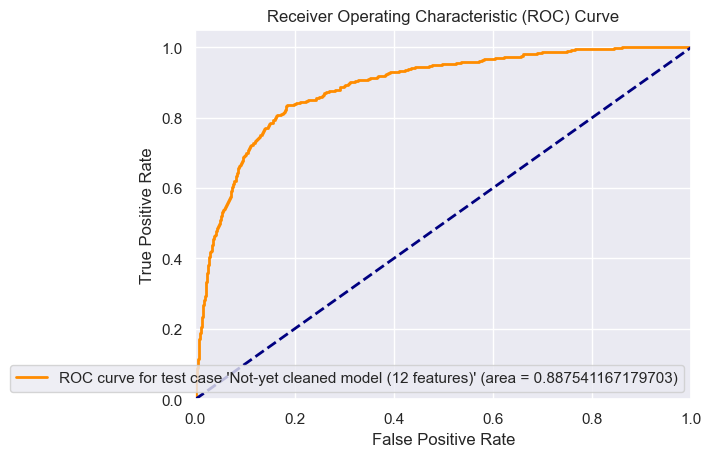

for 'Not-yet cleaned model (12 features)', evaluation metrics: 
Accuracy: 0.9133700550826239, Precision: 0.36473755047106327, Recall: 0.5519348268839104, F1 score: 0.4392220421393841


In [233]:
# uncleaned

x_train_sampling_uncleaned = x_train_sampling.copy()
y_train_sampling_uncleaned = y_train_sampling.copy()
x_test_sampling_uncleaned = x_test_sampling.copy()
y_test_sampling_uncleaned = y_test_sampling.copy()

# model fit
LogReg_sampling_uncleaned = \
LogisticRegression(solver='liblinear').fit(x_train_sampling_uncleaned, y_train_sampling_uncleaned)

y_pred_proba_sampling_uncleaned = \
LogReg_sampling_uncleaned.predict_proba(x_test_sampling_uncleaned)[:, 1]  # Probability of the positive class (class 1)
y_pred_sampling_uncleaned = \
LogReg_sampling_uncleaned.predict(x_test_sampling_uncleaned)

# eval
get_auc_and_plot_roc(y_test_sampling_uncleaned, y_pred_proba_sampling_uncleaned, \
                     "Not-yet cleaned model (12 features)")
get_eval_metrics(y_test_sampling_uncleaned, y_pred_sampling_uncleaned, "Not-yet cleaned model (12 features)")

auc for test case 1st round cleaned model (8 features) : 0.8878018281311167


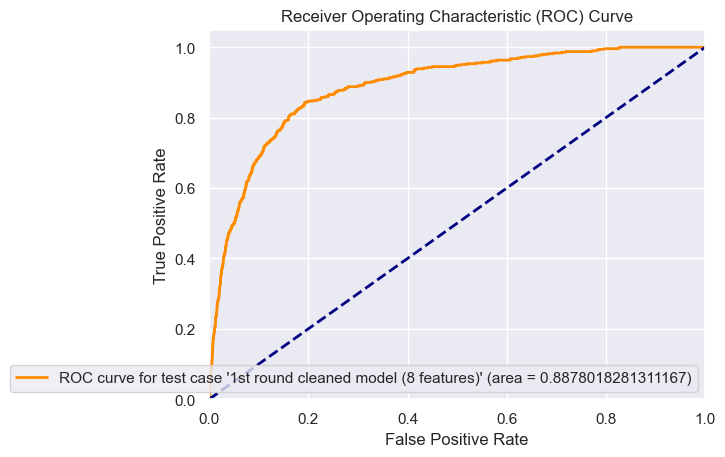

for '1st round cleaned model (8 features)', evaluation metrics: 
Accuracy: 0.9143715573360041, Precision: 0.37012113055181695, Recall: 0.560081466395112, F1 score: 0.44570502431118314


In [234]:
# clean v1
# features_to_be_removed is the feature list from 1st round removal above.

x_train_sampling_cleanV1 = x_train_sampling.drop(columns=features_to_be_removed)
y_train_sampling_cleanV1 = y_train_sampling.copy()
x_test_sampling_cleanV1 = x_test_sampling.drop(columns=features_to_be_removed)
y_test_sampling_cleanV1 = y_test_sampling.copy()

# model fit
LogReg_sampling_cleanV1 = \
LogisticRegression(solver='liblinear').fit(x_train_sampling_cleanV1, y_train_sampling_cleanV1)

y_pred_proba_sampling_cleanV1 = \
LogReg_sampling_cleanV1.predict_proba(x_test_sampling_cleanV1)[:, 1]  # Probability of the positive class (class 1)
y_pred_sampling_cleanV1 = \
LogReg_sampling_cleanV1.predict(x_test_sampling_cleanV1)

# eval
get_auc_and_plot_roc(y_test_sampling_cleanV1, y_pred_proba_sampling_cleanV1, \
                     "1st round cleaned model (8 features)")
get_eval_metrics(y_test_sampling_cleanV1, y_pred_sampling_cleanV1, "1st round cleaned model (8 features)")

auc for test case Final selected feature model (5 features) : 0.8860148268404442


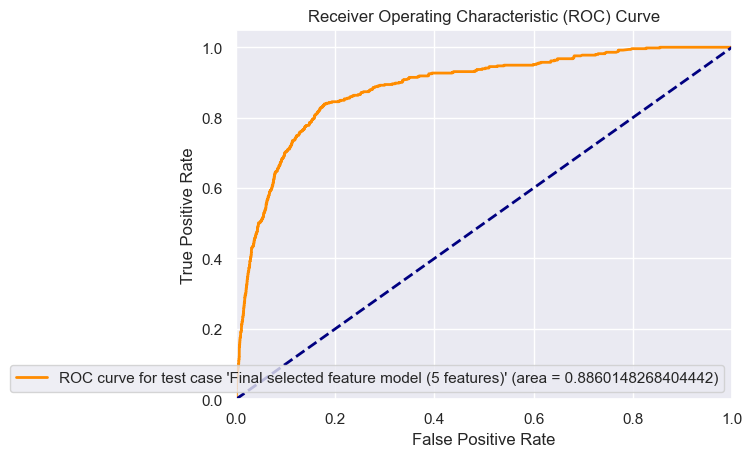

for 'Final selected feature model (5 features)', evaluation metrics: 
Accuracy: 0.9154982473710566, Precision: 0.37257617728531855, Recall: 0.5478615071283096, F1 score: 0.44352844187963725


In [236]:
# clean v2 (final feature selection)
# features_to_be_removed_v2 is the feature list from 2nd round removal above.

x_train_sampling_cleanV2 = x_train_sampling.drop(columns=features_to_be_removed+features_to_be_removed_v2)
y_train_sampling_cleanV2 = y_train_sampling.copy()
x_test_sampling_cleanV2 = x_test_sampling.drop(columns=features_to_be_removed+features_to_be_removed_v2)
y_test_sampling_cleanV2 = y_test_sampling.copy()

LogReg_sampling_cleanV2 = \
LogisticRegression(solver='liblinear').fit(x_train_sampling_cleanV2, y_train_sampling_cleanV2)

y_pred_proba_sampling_cleanV2 = \
LogReg_sampling_cleanV2.predict_proba(x_test_sampling_cleanV2)[:, 1]  # Probability of the positive class (class 1)
y_pred_sampling_cleanV2 = \
LogReg_sampling_cleanV2.predict(x_test_sampling_cleanV2)

# eval
get_auc_and_plot_roc(y_test_sampling_cleanV2, y_pred_proba_sampling_cleanV2, \
                     "Final selected feature model (5 features)")
get_eval_metrics(y_test_sampling_cleanV2, y_pred_sampling_cleanV2, "Final selected feature model (5 features)")

Best hyperparameters: {'Cs': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30], 'cv': 3, 'penalty': 'l1'}
Best C value:  [0.001]
auc for test case Regularized model : 0.7422678507927272


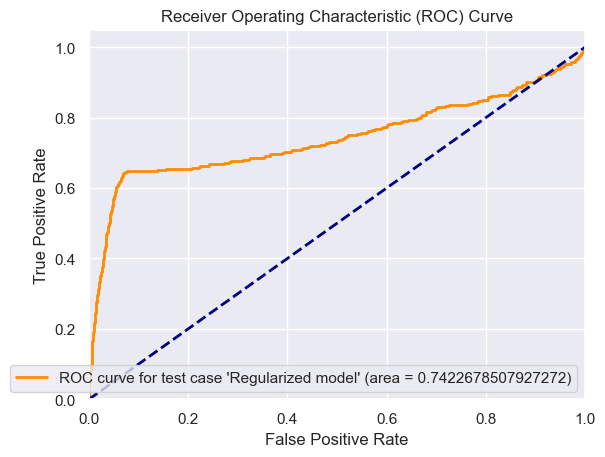

for 'Regularized model', evaluation metrics: 
Accuracy: 0.9053580370555834, Precision: 0.35294117647058826, Recall: 0.6476578411405295, F1 score: 0.45689655172413796


In [238]:
# regularization

grid_search.fit(x_train_sampling_uncleaned, y_train_sampling_uncleaned)   # use the uncleaned feature set (12 features)

print("Best hyperparameters:", grid_search.best_params_)

# Evaluate model performance with best hyperparameters
best_model = grid_search.best_estimator_
print("Best C value: ", best_model.C_)

y_pred_proba_sampling_regul = \
best_model.predict_proba(x_test_sampling_uncleaned)[:, 1]  # Probability of the positive class (class 1)
y_pred_sampling_regul = \
best_model.predict(x_test_sampling_uncleaned)

# eval
get_auc_and_plot_roc(y_test_sampling_uncleaned, y_pred_proba_sampling_regul, \
                     "Regularized model")
get_eval_metrics(y_test_sampling_uncleaned, y_pred_sampling_regul, "Regularized model")

### 6.3 Skewed dataset analysis
We can see for all of the models trained from re-sampled dataset (with 33% positive and 67% negative):

- re-sampled models have higher accuracy (>91%) compared to the model from original-skewed dataset (88% accuracy). 
- re-sampled models have higher recall (>54%) compared to original skewed models (37%)
  - that's expected since re-sampled models have more exposure to positive samples, so models would be more prone to predict as positive result. Recall would be higher because false-negative is lower
- re-sampled models have lower precision (37%) compared to original skewed models (>76%)
  - that's expected since re-sampled models have more exposure to positive samples, so models would be more prone to predict as positive result. Precision would be lower because false positive is higher.
- re-sampled models have lower F1 score (44%) compared to original skewed models (50%)



## 7. Conclusion and learning
Apart from what is already covered in step `6. Discussion and Conclusion`, additional leaning from the exploration includes:
- We see accuracy improvement through the re-sampling process. 
- The ratio of positive/negative samples in training dataset, will impact the trade-off between model type I/II errors. More positive samples in training data set, we can reduce type II error but increase type I error, and vice versa.